In [1]:
import cv2
from pathlib import Path
import os
import matplotlib.pyplot as plt
import itertools

In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
from embedding_function import EmbeddingFunction

In [4]:
image_folder = Path(os.getcwd()) / Path("data/images_background")
image_folder

PosixPath('/Users/afolabi/Programming/omniglot/data/images_background')

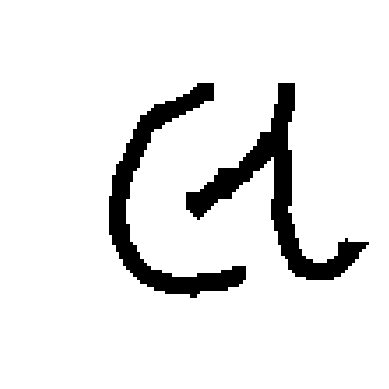

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

NotADirectoryError: [Errno 20] Not a directory: '/Users/afolabi/Programming/omniglot/data/images_background/Alphabet_of_the_Magi/.DS_Store'

In [5]:
# Load the image
for i, folder in enumerate(os.listdir(image_folder)):
    if os.path.isdir(image_folder / Path(folder)):  
        for j, file in enumerate(os.listdir(image_folder / Path(folder))):
            for k, image_url in enumerate(os.listdir(image_folder / Path(folder)/ Path(file))):
                if i == 0 and j == 0 and k == 0:
                    image = cv2.imread(str(Path(image_folder) / Path(folder) / Path(file) / Path(image_url)))

                    # Display the image with matplotlib
                    plt.imshow(image)
                    plt.axis('off')  # Hide axes
                    plt.show()  # IMREAD_UNCHANGED keeps the alpha channel if it's there
                    # print(Path(image_folder) / Path(folder) / Path(file))
                    display(image)
# Note: OpenCV loads images in BGR format by default
# If you want it in RGB format:
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, base_dir, train=True, transform=None, target_transform=None):
        self.base_dir = base_dir
        self.image_labels = [
            [
                str(f"{alphabet}/{character}") for character in os.listdir(Path(self.base_dir) / alphabet) 
                if os.path.isdir(Path(self.base_dir) / alphabet / character)
            ] 
            for alphabet in os.listdir(self.base_dir) if os.path.isdir(Path(self.base_dir) / alphabet)
        ]
        self.image_labels = list(itertools.chain.from_iterable(self.image_labels))
        self.image_dict = {
            img_dir: [image.rstrip(".png") for image in os.listdir(Path(self.base_dir) / img_dir)] 
            for img_dir in self.image_labels
        }
        # self.img_labels = pd.read_csv(annotations_file)
        # self.img_dir = img_dir
        # self.transform = transform
        # self.target_transform = target_transform

    def __len__(self):
        return sum(len(value) for value in self.image_dict.values())

    def __getitem__(self, id):
        filename = id + ".png"
        #find id in self.image_dict
        for key, value in self.image_dict.items():
            if id in value:
                img_dir = key
                label = img_dir
                img_path = Path(self.base_dir) / img_dir / filename
                image = cv2.imread(str(img_path))
                return image,  label
        raise ValueError(f"ID {id} not found in dataset")
        
        


In [7]:
dataset = ImageDataset(image_folder)
dataset.image_dict
dataset.__getitem__("0899_01")

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [25]:
import random
import numpy as np
import torch 
from loss import ProtoNetLoss
import torch.optim as optim

n_c = 10
n_s = 5
n_q = 5

nn_kwargs = {
    "input_dims": (3, 105, 105),
    "hidden_dim": 64,
    "output_dim": 64,
}
embedding_fn = EmbeddingFunction(**nn_kwargs)
# Zero the parameter gradients
optimizer = optim.SGD(embedding_fn.parameters(), lr=0.01)
loss_fn = ProtoNetLoss(reduction="mean")


for _ in range(1000):
    v = random.sample(dataset.image_labels, n_c)
    optimizer.zero_grad()
    episode_loss = torch.tensor(0.0, requires_grad=True)
    centroids = dict()
    query_sets = dict()

    for label in v:
        support_set_ids = random.sample(dataset.image_dict[label], n_s)
        query_set_ids = random.sample(dataset.image_dict[label], n_q)
        support_set = [
            torch.from_numpy(np.transpose(dataset.__getitem__(id)[0], (2, 0, 1)))/255 for id in support_set_ids
        ]
        query_sets[label] = [
            torch.from_numpy(np.transpose(dataset.__getitem__(id)[0], (2, 0, 1)))/255 for id in query_set_ids
        ]

        centroids[label] = embedding_fn(torch.stack(support_set)).mean(dim=0)

    
    for label in v:   
        non_target_centroids = torch.stack([centroids[key] for key in v if key != label])
        target_centroid = centroids[label]
        query_set = query_sets[label]
        # print(target_centroid.shape)
        for query in query_set:
            output = embedding_fn(query.view(1, 3, 105, 105))
            episode_loss = episode_loss + loss_fn(output, target_centroid, non_target_centroids)
            # Backward pass: compute gradient of the loss with respect to model parameters
    episode_loss.backward()
    optimizer.step()


: 

: 